Data:
Amazon books review from http://jmcauley.ucsd.edu/data/amazon/

In [1]:
data = 'reviews_Books_5.json.gz'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import pandas

In [3]:
import gzip
def parse(path, topN=None):
    with gzip.open(path, 'r') as g:
        lc = 0
        for l in g:
            lc += 1
            yield eval(l)
            if topN != None and lc == topN: break

In [4]:
# top 3 items
for i in parse(data, 3): print(i)

{'reviewerID': 'A10000012B7CGYKOMPQ4L', 'asin': '000100039X', 'reviewerName': 'Adam', 'helpful': [0, 0], 'unixReviewTime': 1355616000, 'reviewText': 'Spiritually and mentally inspiring! A book that allows you to question your morals and will help you discover who you really are!', 'overall': 5.0, 'reviewTime': '12 16, 2012', 'summary': 'Wonderful!'}
{'reviewerID': 'A2S166WSCFIFP5', 'asin': '000100039X', 'reviewerName': 'adead_poet@hotmail.com "adead_poet@hotmail.com"', 'helpful': [0, 2], 'unixReviewTime': 1071100800, 'reviewText': "This is one my must have books. It is a masterpiece of spirituality. I'll be the first to admit, its literary quality isn't much. It is rather simplistically written, but the message behind it is so powerful that you have to read it. It will take you to enlightenment.", 'overall': 5.0, 'reviewTime': '12 11, 2003', 'summary': 'close to god'}
{'reviewerID': 'A1BM81XB4QHOA3', 'asin': '000100039X', 'reviewerName': 'Ahoro Blethends "Seriously"', 'helpful': [0, 0]

In [5]:
# limit to only reviews with more than 10 feedbacks
def extractWithFeedback(data, n, minTotalFeedbacks=10):
    reviews_w_fb = []
    for i in parse(data):
        if len(i['reviewText']) < 10:
            continue
        if i['helpful'][1] > minTotalFeedbacks:
            reviews_w_fb.append(i)
        if len(reviews_w_fb) == n:
            break
    return reviews_w_fb

In [6]:
# take the frist 10,000 reviews, split 0.6/0.2/0.2 for train/dev/test
def getData(data, totalSample, useCache=True, minTotalFeedbacks=10, split=[0.6,0.2,0.2]):
    import pickle
    import os
    if useCache and os.path.isfile("train_data.p") and os.path.isfile("dev_data.p") and os.path.isfile("test_data.p"):
        print("using cached data")
        with open("train_data.p", "rb") as f:
            train_data = pickle.load(f)
        with open("dev_data.p", "rb") as f:
            dev_data = pickle.load(f)
        with open("test_data.p", "rb") as f:
            test_data = pickle.load(f)
        return train_data, dev_data, test_data
            
    # probably not needed, but shuffle the data just to be safe
    samples = np.random.permutation(extractWithFeedback(data, totalSample, minTotalFeedbacks))
    split_idx1 = int(split[0]*len(samples))
    split_idx2 = split_idx1+int(split[1]*len(samples))
    train_data = samples[:split_idx1]
    dev_data = samples[split_idx1:split_idx2]
    test_data = samples[split_idx2:]
    
    with open("train_data.p", "wb") as f:
        pickle.dump(train_data, f)
    with open("dev_data.p", "wb") as f:
        pickle.dump(dev_data, f)
    with open("test_data.p", "wb") as f:
        pickle.dump(test_data, f)
    
    return train_data, dev_data, test_data

In [19]:
total_sample = 10000
#train_data, dev_data, test_data = getData(data, total_sample, useCache=True)
train_targets_prob = [d["helpful"][0]*1.0/d["helpful"][1] for d in train_data]
dev_targets_prob = [d["helpful"][0]*1.0/d["helpful"][1] for d in dev_data]
test_targets_prob = [d["helpful"][0]*1.0/d["helpful"][1] for d in test_data]

In [8]:
#nltk.tokenize.word_tokenize(train_data[0]['reviewText'])
nltk.tokenize.sent_tokenize(train_data[0]['reviewText'])

['After reading The Farseer Trilogy which was very promising, I decided to take another chance with the author and try The Ship of Magic series.',
 'This first book is very silly.',
 "The concept of a liveship which speaks to it's  occupants was intriguing but it loses it's appeal as the characters were  very annoying, and the magic was very unsophisticated.",
 'I tried very hard to  find some good in this novel but it falls short of anything spectacular.',
 'Only for the extreemely imaginative and open minded.',
 'If you have your feet  planted firmly on the ground, this fantasy novel is not for you.',
 'Goodkind  fans will find this novel a hard read.',
 'The Farseer trilogy is far better.']

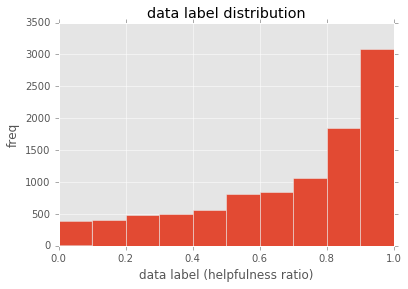

In [9]:
def visualizeLabels():
    plt.hist(train_targets_prob+dev_targets_prob+test_targets_prob)
    plt.title("data label distribution")
    plt.xlabel("data label (helpfulness ratio)")
    plt.ylabel("freq")
visualizeLabels()

In [20]:
train_targets = [1 if p>0.8 else 0 for p in train_targets_prob]
dev_targets = [1 if p>0.8 else 0 for p in dev_targets_prob]
test_targets = [1 if p>0.8 else 0 for p in test_targets_prob]

In [21]:
import sklearn.metrics as metrics
def score_batch(pred_probs, targets):
    pred = [1 if p>0.5 else 0 for p in pred_probs]
    accuracy = metrics.accuracy_score(targets, pred)
    precision = metrics.precision_score(targets, pred)
    recall = metrics.recall_score(targets, pred)
    f1 = metrics.f1_score(targets, pred)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [22]:
sum(train_targets)+sum(dev_targets)+sum(test_targets)

4814

In [47]:
# baseline score - all positive
print("baseline train score, all positive class")
print("train:")
print(score_batch([1]*len(train_targets), train_targets))
print("dev:")
print(score_batch([1]*len(dev_targets), dev_targets))
print("test:")
print(score_batch([1]*len(test_targets), test_targets))

print("baseline train score, all negative class")
print("train:")
print(score_batch([0]*len(train_targets), train_targets))
print("dev:")
print(score_batch([0]*len(dev_targets), dev_targets))
print("test:")
print(score_batch([0]*len(test_targets), test_targets))

baseline train score, all positive class
train:
{'f1': 0.65891819400983453, 'recall': 1.0, 'precision': 0.49133333333333334, 'accuracy': 0.49133333333333334}
dev:
{'f1': 0.63341305090536393, 'recall': 1.0, 'precision': 0.46350000000000002, 'accuracy': 0.46350000000000002}
test:
{'f1': 0.63899285471248723, 'recall': 1.0, 'precision': 0.46949999999999997, 'accuracy': 0.46949999999999997}
baseline train score, all negative class
train:
{'f1': 0.0, 'recall': 0.0, 'precision': 0.0, 'accuracy': 0.50866666666666671}
dev:
{'f1': 0.0, 'recall': 0.0, 'precision': 0.0, 'accuracy': 0.53649999999999998}
test:
{'f1': 0.0, 'recall': 0.0, 'precision': 0.0, 'accuracy': 0.53049999999999997}


In [12]:
# tokenize the datasets
def tokenizeAll():
    for dataset in (train_data, dev_data, test_data):
        for data in dataset:
            data['reviewWordTokens'] = word_tokenize(data['reviewText'])
            data['reviewSentences'] = sent_tokenize(data['reviewText'])
tokenizeAll()

In [13]:
# apply part of speech tags
def tagPOSAll():
    for dataset in (train_data, dev_data, test_data):
        for data in dataset:
            data['reviewTextPOS'] = nltk.pos_tag(data['reviewWordTokens'])
tagPOSAll()

In [17]:
# save works
import pickle
with open('train_data_pos.p', 'wb') as f:
    pickle.dump(train_data, f)
with open('test_data_pos.p', 'wb') as f:
    pickle.dump(test_data, f)
with open('dev_data_pos.p', 'wb') as f:
    pickle.dump(dev_data, f)

In [1]:
# load data
import pickle
with open('train_data_pos.p', 'rb') as f:
    train_data = pickle.load(f)
with open('test_data_pos.p', 'rb') as f:
    test_data = pickle.load(f)
with open('dev_data_pos.p', 'rb') as f:
    dev_data = pickle.load(f)

In [14]:
import collections
pos_tag_dist = collections.Counter((pos[1] for pos in d['reviewTextPOS'] for d in train_data))

,'',(,),",",.,:,CC,CD,DT,EX,...,RP,TO,VB,VBD,VBG,VBN,VBP,VBZ,WRB,``
0,18000,6000,6000,120000,168000,18000,108000,78000,324000,6000,...,12000,60000,108000,144000,96000,60000,108000,78000,24000,18000


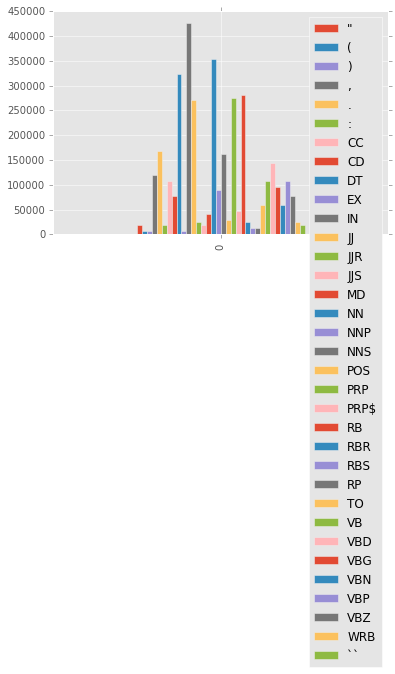

In [15]:
def visualizePOS():
    pos_result = {}
    orig_result = dict(pos_tag_dist)
    for pos in orig_result:
        pos_result[pos] = [orig_result[pos]]
    df = pandas.DataFrame(pos_result)
    df.plot.bar()
    return df
visualizePOS()

In [16]:
sorted(list(pos_tag_dist))

["''",
 '(',
 ')',
 ',',
 '.',
 ':',
 'CC',
 'CD',
 'DT',
 'EX',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'MD',
 'NN',
 'NNP',
 'NNS',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'TO',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WRB',
 '``']

In [6]:
# class to hold feature functions and mean/stdev for standarization
class lm_model:
    def __init__(self):
        self.funcs = {}
        self.means = {}
        self.stdevs = {}
        self.model = None
    def registerFeature(self, func_name, func_body):
        self.funcs[func_name] = func_body
    def deregisterFeature(self, func_name):
        del self.funcs[func_name]
    def listFunctions(self):
        for name in self.funcs:
            yield name
    def getFeatureVal(self, data_point, func_name, args=None, standardize=False):
        if args == None:
            val = self.funcs[func_name](data_point)
        else:
            val = self.funcs[func_name](data_point, *args)
        if standardize:
            val = (val-self.means[func_name])*1.0/self.stdevs[func_name]
        return val
    def trainFeatures(self, data_list, arg_dict=None, fromScratch=False):
        train_count = 0
        for name in self.funcs:
            if fromScratch or name not in self.means:
                results = []
                for data_point in data_list:
                    arg_list = None
                    if arg_dict != None and name in arg_dict:
                        arg_list = arg_dict[name]
                    results.append(self.getFeatureVal(data_point, name, arg_list))
                self.means[name] = sum(results)*1.0/len(results)
                self.stdevs[name] = np.std(results)
                train_count += 1
        print("total %s functions trained"%train_count)
    def makeData(self, data_list, arg_dict=None, standardize=False, feature_filter=None):
        results = []
        for data_point in data_list:
            data_row = []
            for name in self.funcs:
                if feature_filter != None and name not in feature_filter:
                    continue
                arg_list = None
                if arg_dict != None and name in arg_dict:
                    arg_list = arg_dict[name]
                data_row.append(self.getFeatureVal(data_point, name, arg_list, standardize))
            results.append(data_row)
        return results
    
    def coef(self, feature_filters=None):
        if feature_filters != None:
            feature_list = [f for f in feature_filters]
        else:
            feature_list = [name for name in self.funcs]
        return zip(feature_list, self.model.coef_[0])
    
    def trainModel(self, train_data_list, targets, reg="l1"):
        self.model = LogisticRegression(penalty=reg)
        self.model.fit(train_data_list, targets)
        
    def score(self, score_data_list, targets):
        pred = self.model.predict(score_data_list)
        accuracy = metrics.accuracy_score(targets, pred)
        precision = metrics.precision_score(targets, pred)
        recall = metrics.recall_score(targets, pred)
        f1 = metrics.f1_score(targets, pred)
        return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [13]:
model = lm_model()

In [14]:
# feature functions
def typeToTokenRatio(data):
    tokens = data['reviewWordTokens']
    types = set([t.lower() for t in tokens])
    return len(types)*1.0/len(tokens)

def meanWordLength(data):
    wordlengths = [len(t) for t in data['reviewWordTokens'] if t not in string.punctuation]
    return sum(wordlengths)*1.0/len(wordlengths)

def punctuationRatio(data):
    puncs = 0.0
    for t in data['reviewWordTokens']:
        if t in string.punctuation:
            puncs += 1
    return puncs/len(data['reviewWordTokens'])

def posRatio(data, target_pos):
    counts = 0.0
    for pos in data['reviewTextPOS']:
        if target_pos == pos[1]:
            counts += 1
    return counts/len(data['reviewTextPOS'])

In [15]:
model.registerFeature("log text length", lambda d: np.log(len(d['reviewText'])))
model.registerFeature("type-token ratio", typeToTokenRatio)
model.registerFeature("mean word length", meanWordLength)
model.registerFeature("mean sent length", lambda d: np.mean([len(s) for s in d['reviewSentences']]))
model.registerFeature("sent length stdev", lambda d: np.std([len(s) for s in d['reviewSentences']]))
model.registerFeature("punctuation ratio", punctuationRatio)
model.registerFeature("punctuation ratio", punctuationRatio)
for target_pos in ['CC','CD','DT','EX','IN','JJ','JJR',
    'JJS','MD','NN','NNP','NNS','POS',
    'PRP','PRP$','RB','RBR','RBS','RP',
    'TO','VB','VBD','VBG','VBN','VBP',
    'VBZ','WRB']:
    model.registerFeature("POS %s ratio"%target_pos, lambda d: posRatio(d, target_pos))

In [16]:
import numpy as np
import string
model.trainFeatures(train_data)

total 33 functions trained


In [17]:
train_data_feaurized = model.makeData(train_data, standardize=True)
dev_data_feaurized = model.makeData(dev_data, standardize=True)
test_data_feaurized = model.makeData(test_data, standardize=True)

In [530]:
model.trainModel(train_data_feaurized, train_targets)

In [531]:
model.score(train_data_feaurized, train_targets)

{'accuracy': 0.59016666666666662,
 'f1': 0.59037148092620362,
 'precision': 0.58003273322422255,
 'recall': 0.60108548168249665}

In [532]:
model.score(test_data_feaurized, test_targets)

{'accuracy': 0.59099999999999997,
 'f1': 0.58307849133537204,
 'precision': 0.55913978494623651,
 'recall': 0.60915867944621938}

In [533]:
model.score(dev_data_feaurized, dev_targets)

{'accuracy': 0.60799999999999998,
 'f1': 0.59336099585062252,
 'precision': 0.5714285714285714,
 'recall': 0.61704422869471409}

In [536]:
sorted(model.coef(), key=lambda k: abs(k[1]), reverse=True)

[('type-token ratio', -0.33266621331865465),
 ('mean word length', 0.16248024378860482),
 ('log text length', 0.14325177157826041),
 ('sent length stdev', -0.028205932682173151),
 ('mean sent length', 0.022583618437599724),
 ('punctuation ratio', 0.010542609681562794),
 ('POS TO ratio', -0.0028630683076006766),
 ('POS RBS ratio', -0.00011303746477102646),
 ('POS VB ratio', -0.00010012906397317523),
 ('POS CD ratio', -9.5386792831340846e-05),
 ('POS POS ratio', -3.3997472363860788e-05),
 ('POS JJS ratio', -3.0336420824605684e-05),
 ('POS VBZ ratio', -2.859747954438832e-05),
 ('POS DT ratio', -2.1241087187688864e-05),
 ('POS CC ratio', -1.9771803399333528e-05),
 ('POS NNS ratio', -1.0801057856580179e-05),
 ('POS VBD ratio', -9.7336605905273662e-06),
 ('POS RP ratio', -6.5363060858305941e-06),
 ('POS NN ratio', -6.2049037393560374e-06),
 ('POS JJ ratio', -5.1928013121076098e-06),
 ('POS MD ratio', -3.7640440982000175e-06),
 ('POS RB ratio', -2.8689114690362422e-06),
 ('POS RBR ratio', -2.

### Train with NN

In [2]:
import tensorflow as tf

In [3]:
class TextModel(object):
    
    def __init__(self):
        self.learning_rate_ = tf.constant(0.01, name="learning_rate")
        
        self.hidden1_size = 300
        self.hidden2_size = 200
        self.input_size = 33
        
        self.input_w_ = tf.placeholder(tf.float32, [None, None], name="w")
        self.target_y_ = tf.placeholder(tf.float32, [None], name="y")
        
        with tf.variable_scope("hidden1"):
            self.w1 = tf.get_variable("w1", shape=[self.input_size, self.hidden1_size], dtype=tf.float32,
                                         initializer=tf.contrib.layers.xavier_initializer())
            self.b1 = tf.get_variable("b1", dtype=tf.float32, 
                         initializer=tf.zeros_initializer([self.hidden1_size]))
            self.h1 = tf.tanh(tf.matmul(self.input_w_, self.w1) + self.b1, name="h1")
            
        with tf.variable_scope("hidden2"):
            self.w2 = tf.get_variable("w2", shape=[self.hidden1_size, self.hidden2_size], dtype=tf.float32,
                                         initializer=tf.contrib.layers.xavier_initializer())
            self.b2 = tf.get_variable("b2", dtype=tf.float32, 
                         initializer=tf.zeros_initializer([self.hidden2_size]))
            self.h2 = tf.tanh(tf.matmul(self.h1, self.w2) + self.b2, name="h2")
            
        with tf.variable_scope("output_layer"):
            self.w_out = tf.get_variable("W_out", shape=[self.hidden2_size, 1], dtype=tf.float32, 
                         initializer=tf.contrib.layers.xavier_initializer())
            self.b_out = tf.get_variable("b_out", dtype=tf.float32, 
                           initializer=tf.zeros_initializer([1]))
            self.logits_ = tf.add(tf.matmul(self.h2, self.w_out), self.b_out, name="logits")
            
        with tf.name_scope("loss_function"):
            self.point_loss_ = tf.nn.sigmoid_cross_entropy_with_logits(tf.squeeze(self.logits_), self.target_y_)
            self.loss_ = tf.reduce_mean(self.point_loss_)
            
        with tf.name_scope("train_ops"):
            optimizer = tf.train.GradientDescentOptimizer(self.learning_rate_)
            self.train_step_ = optimizer.minimize(self.loss_)
            
        with tf.name_scope("Prediction"):
            self.pred_proba_ = tf.sigmoid(self.logits_, name="pred_proba")

In [4]:
def batchGenerator(dataset, targets, batch_size):
    for i in xrange(0, len(dataset), batch_size):
        yield dataset[i:i+batch_size], targets[i:i+batch_size]

In [23]:
for r in batchGenerator(train_data_feaurized[:2], train_targets[:2], 1):
    print r

([[-0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, 0.20136177788428367, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.58823082969047591, -0.80326880073753038, -0.50072973275733268, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038, -0.67576784164650661, -0.80326880073753038, -0.012109572690456264, -0.63775047019366837, -0.80326880073753038, -0.80326880073753038, -0.80326880073753038]], [0])
([[3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 3.0575408183417094, 0.66297400982324628, 

In [25]:
# run training
trained_filename = 'tf_saved/nn_with_manual_features'
batch_size = 5
learning_rate = 0.1
num_epochs = 100
import time
import utils; reload(utils)

def runTraining(print_interval=20):
    with tf.Graph().as_default(), tf.Session() as session:
        tf.set_random_seed(42)
        with tf.variable_scope("model", reuse=None):
            lm = TextModel()
        session.run(tf.initialize_all_variables())
        saver = tf.train.Saver()
        
        for epoch in xrange(1,num_epochs+1):
            t0_epoch = time.time()
            bi = batchGenerator(train_data_feaurized, train_targets, batch_size)
            if epoch == 1 or epoch%print_interval == 0:
                print "[epoch %d] Starting epoch %d" % (epoch, epoch)
            cost = 0.0
            for (w, y,) in bi:
                feed_dict = {
                    lm.learning_rate_: learning_rate,
                    lm.input_w_: w,
                    lm.target_y_: y
                }
                _, loss_val = session.run([lm.train_step_, lm.loss_], feed_dict)
                cost += loss_val
            
            if epoch%print_interval == 0:
                print "%s: total loss: %.03f" % ("Training", cost)
                print "[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch))

                print("train score")
                bi = batchGenerator(train_data_feaurized, train_targets, len(train_data))
                for (w,y) in bi:
                    feed_dict = { lm.input_w_:w}
                    pred_prob = session.run(lm.pred_proba_, feed_dict)
                    print(score_batch(pred_prob, y))

                print("dev score")
                bi = batchGenerator(dev_data_feaurized, dev_targets, len(dev_data))
                for (w,y) in bi:
                    feed_dict = { lm.input_w_:w}
                    pred_prob = session.run(lm.pred_proba_, feed_dict)
                    print(score_batch(pred_prob, y))
                
        print("train score")
        bi = batchGenerator(train_data_feaurized, train_targets, len(train_data))
        for (w,y) in bi:
            feed_dict = { lm.input_w_:w}
            pred_prob = session.run(lm.pred_proba_, feed_dict)
            print(score_batch(pred_prob, y))

        print("dev score")
        bi = batchGenerator(dev_data_feaurized, dev_targets, len(dev_data))
        for (w,y) in bi:
            feed_dict = { lm.input_w_:w}
            pred_prob = session.run(lm.pred_proba_, feed_dict)
            print(score_batch(pred_prob, y))
        # Save final model
        saver.save(session, trained_filename)
#runTraining()

In [24]:
# get test score
trained_filename = 'tf_saved/nn_with_manual_features'
batch_size = 5
learning_rate = 0.1
num_epochs = 100

with tf.Graph().as_default(), tf.Session() as session:
    with tf.variable_scope("model", reuse=None):
        lm = TextModel()
        session.run(tf.initialize_all_variables())
        saver = tf.train.Saver()
    saver = tf.train.Saver()
    saver.restore(session, trained_filename)
    
    print("test score")
    bi = batchGenerator(test_data_feaurized,test_targets, len(test_data))
    for (w,y) in bi:
        feed_dict = { lm.input_w_:w}
        pred_prob = session.run(lm.pred_proba_, feed_dict)
        print(score_batch(pred_prob, y))

test score
{'f1': 0.63042525208241995, 'recall': 0.76570820021299257, 'precision': 0.53576751117734722, 'accuracy': 0.57850000000000001}


In [27]:
trained_filename = 'tf_saved/nn_with_manual_features_2'
batch_size = 5
learning_rate = 0.1
num_epochs = 40
runTraining()

[epoch 1] Starting epoch 1
[epoch 20] Starting epoch 20
Training: total loss: 793.505
[epoch 20] Completed in 0:00:01
train score
{'f1': 0.64647949434073215, 'recall': 0.74592944369063774, 'precision': 0.57042801556420231, 'accuracy': 0.59916666666666663}
dev score
{'f1': 0.62901744719926544, 'recall': 0.73894282632146713, 'precision': 0.54756195043964828, 'accuracy': 0.59599999999999997}
[epoch 40] Starting epoch 40
Training: total loss: 793.163
[epoch 40] Completed in 0:00:01
train score
{'f1': 0.65917816010237451, 'recall': 0.78629579375848035, 'precision': 0.56744186046511624, 'accuracy': 0.60050000000000003}
dev score
{'f1': 0.6351893095768375, 'recall': 0.76914778856526433, 'precision': 0.54097116843702575, 'accuracy': 0.59050000000000002}
train score
{'f1': 0.65917816010237451, 'recall': 0.78629579375848035, 'precision': 0.56744186046511624, 'accuracy': 0.60050000000000003}
dev score
{'f1': 0.6351893095768375, 'recall': 0.76914778856526433, 'precision': 0.54097116843702575, 'acc

In [28]:
# get test score
trained_filename = 'tf_saved/nn_with_manual_features_2'

with tf.Graph().as_default(), tf.Session() as session:
    with tf.variable_scope("model", reuse=None):
        lm = TextModel()
        session.run(tf.initialize_all_variables())
        saver = tf.train.Saver()
    saver = tf.train.Saver()
    saver.restore(session, trained_filename)
    
    print("test score")
    bi = batchGenerator(test_data_feaurized,test_targets, len(test_data))
    for (w,y) in bi:
        feed_dict = { lm.input_w_:w}
        pred_prob = session.run(lm.pred_proba_, feed_dict)
        print(score_batch(pred_prob, y))

test score
{'f1': 0.64282599215002179, 'recall': 0.78487752928647503, 'precision': 0.54431314623338256, 'accuracy': 0.59050000000000002}
